In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/UFPR/TCC/UHCS/Rev. 02

In [ ]:
!ls

ImagePreprocessing_02.ipynb  new_data_labels.csv
MobileNetV2_02.ipynb	     new_dataset
model2			     Web_Scrapping_New_Dataset.ipynb


In [ ]:
# lOADING AND SPLITTING THE IMAGES

In [ ]:
img = cv2.imread('../Rev. 01/img/martensite/micrograph99.png')
img.shape

(484, 645, 3)

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    '../Rev. 01/img/',
    label_mode='categorical',
    color_mode='rgb', 
    batch_size=32,
    image_size=(484, 645),
    shuffle=True,
    seed=101,
    validation_split=0.25,
    subset='training'
)

validation = tf.keras.utils.image_dataset_from_directory(
    '../Rev. 01/img/',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(484, 645),
    shuffle=True,
    seed=101,
    validation_split=0.25,
    subset='validation'
)

Found 748 files belonging to 6 classes.
Using 561 files for training.
Found 748 files belonging to 6 classes.
Using 187 files for validation.


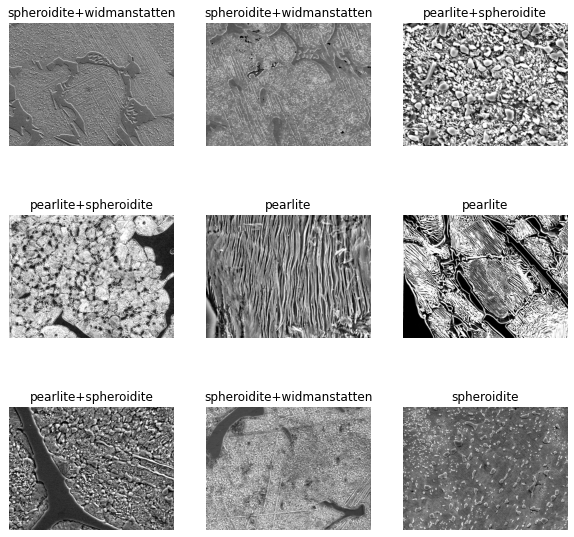

In [ ]:
class_names = train.class_names

plt.figure(figsize=(10,10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[np.where(labels[i])[0][0]])
        plt.axis('off')

In [ ]:
val_batches = tf.data.experimental.cardinality(validation)
test = validation.take(val_batches // 5)
validation = validation.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test))

Number of validation batches: 5
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# DATA AUGMENTATION

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])

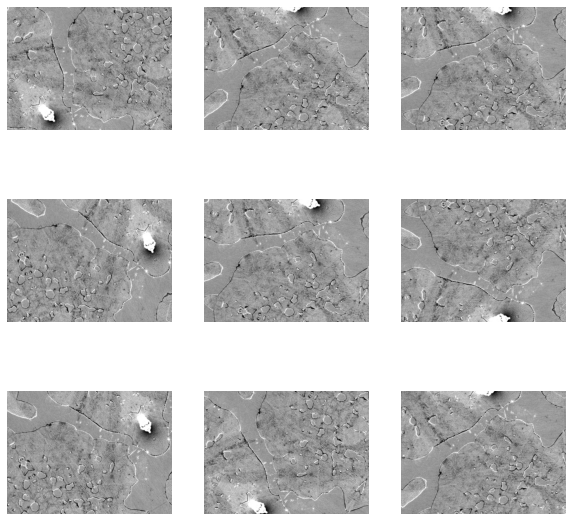

In [ ]:
for image, _ in train.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255, cmap='gray')
        plt.axis('off')

In [ ]:
# MOBILENET EXPECTS PIXEL VALUES BETWEEN -1 AND 1, SO WE NEED TO RESCALE THE IMAGES

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = (484,645) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 21, 1280)


In [ ]:
# FEATURE EXTRACTION

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 484, 645, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 242, 323, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 242, 323, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# ADDING A CLASSIFICATION HEAD
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# APPLYING A DENSE LAYER
prediction_layer = tf.keras.layers.Dense(6)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [ ]:
# BUILDING THE MODEL
inputs = tf.keras.Input(shape=(484, 645,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# COMPILING THE MODEL
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 484, 645, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 484, 645, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 484, 645, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 484, 645, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 21, 1280)     2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# TRAINING THE MODEL
initial_epochs = 15
loss0, accuracy0 = model.evaluate(validation)

5/5 [==============================] - 35s 6s/step - loss: 1.9695 - accuracy: 0.1871


In [ ]:
print('Initial loss: {:.2f}'.format(loss0))
print('Initial accuracy: {:.2f}'.format(accuracy0))

Initial loss: 1.97
Initial accuracy: 0.19


In [ ]:
history = model.fit(train,
                   epochs=initial_epochs,
                   validation_data=validation)

Epoch 1/15
18/18 [==============================] - 175s 9s/step - loss: 1.7950 - accuracy: 0.2513 - val_loss: 1.4964 - val_accuracy: 0.4516
Epoch 2/15
18/18 [==============================] - 166s 9s/step - loss: 1.5214 - accuracy: 0.4260 - val_loss: 1.2573 - val_accuracy: 0.5871
Epoch 3/15
18/18 [==============================] - 167s 9s/step - loss: 1.3911 - accuracy: 0.4955 - val_loss: 1.2011 - val_accuracy: 0.6258
Epoch 4/15
18/18 [==============================] - 168s 9s/step - loss: 1.2789 - accuracy: 0.5401 - val_loss: 1.1562 - val_accuracy: 0.6129
Epoch 5/15
18/18 [==============================] - 168s 9s/step - loss: 1.2390 - accuracy: 0.5526 - val_loss: 1.1016 - val_accuracy: 0.6387
Epoch 6/15
18/18 [==============================] - 168s 9s/step - loss: 1.1731 - accuracy: 0.5865 - val_loss: 0.9594 - val_accuracy: 0.6839
Epoch 7/15
18/18 [==============================] - 163s 9s/step - loss: 1.1041 - accuracy: 0.6096 - val_loss: 0.9977 - val_accuracy: 0.6710
Epoch 8/15
18

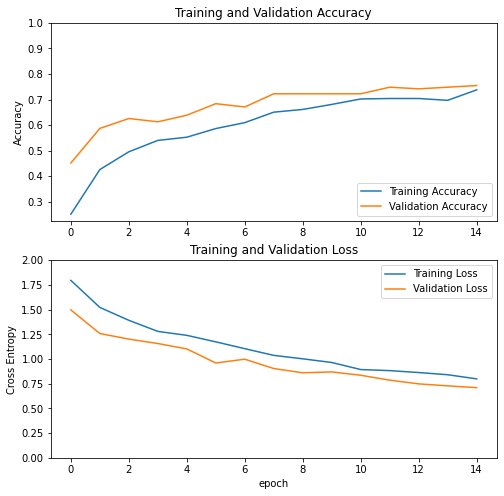

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('model2')

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


In [ ]:
#model.load_weights('model2')

In [ ]:
# MODEL EVALUATION
loss, accuracy = model.evaluate(test)
print('Test Accuracy: ', accuracy)

1/1 [==============================] - 8s 8s/step - loss: 0.7620 - accuracy: 0.7188
Test Accuracy:  0.71875


In [ ]:
# FINE TUNING 

In [ ]:
base_model.trainable = True

In [ ]:
print('Number of layers in the base model: ', len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 484, 645, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 484, 645, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 484, 645, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 484, 645, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 21, 1280)     2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validation)

Epoch 15/25
18/18 [==============================] - 281s 15s/step - loss: 0.2217 - accuracy: 0.7469 - val_loss: 0.1631 - val_accuracy: 0.7871
Epoch 16/25
18/18 [==============================] - 265s 15s/step - loss: 0.1671 - accuracy: 0.8235 - val_loss: 0.1479 - val_accuracy: 0.8194
Epoch 17/25
18/18 [==============================] - 285s 16s/step - loss: 0.1616 - accuracy: 0.8289 - val_loss: 0.1370 - val_accuracy: 0.8452
Epoch 18/25
18/18 [==============================] - 265s 15s/step - loss: 0.1483 - accuracy: 0.8485 - val_loss: 0.1306 - val_accuracy: 0.8258
Epoch 19/25
18/18 [==============================] - 268s 15s/step - loss: 0.1477 - accuracy: 0.8271 - val_loss: 0.1218 - val_accuracy: 0.8516
Epoch 20/25
18/18 [==============================] - 274s 15s/step - loss: 0.1338 - accuracy: 0.8663 - val_loss: 0.1185 - val_accuracy: 0.8581
Epoch 21/25
18/18 [==============================] - 274s 15s/step - loss: 0.1257 - accuracy: 0.8734 - val_loss: 0.1151 - val_accuracy: 0.8645

In [ ]:
model.save('model2')

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

#loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

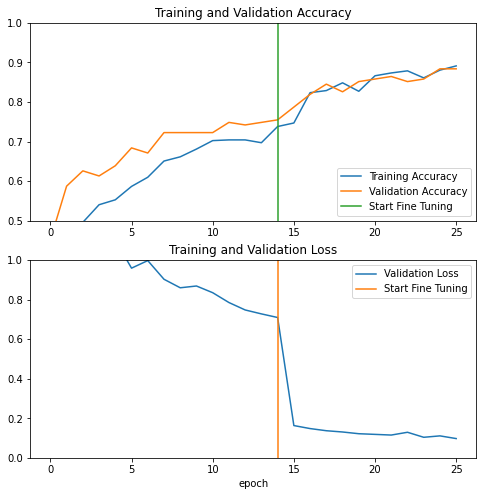

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# EVALUATION AND PREDICTION

In [ ]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

1/1 [==============================] - 6s 6s/step - loss: 0.2690 - accuracy: 0.8750
Test accuracy : 0.875


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

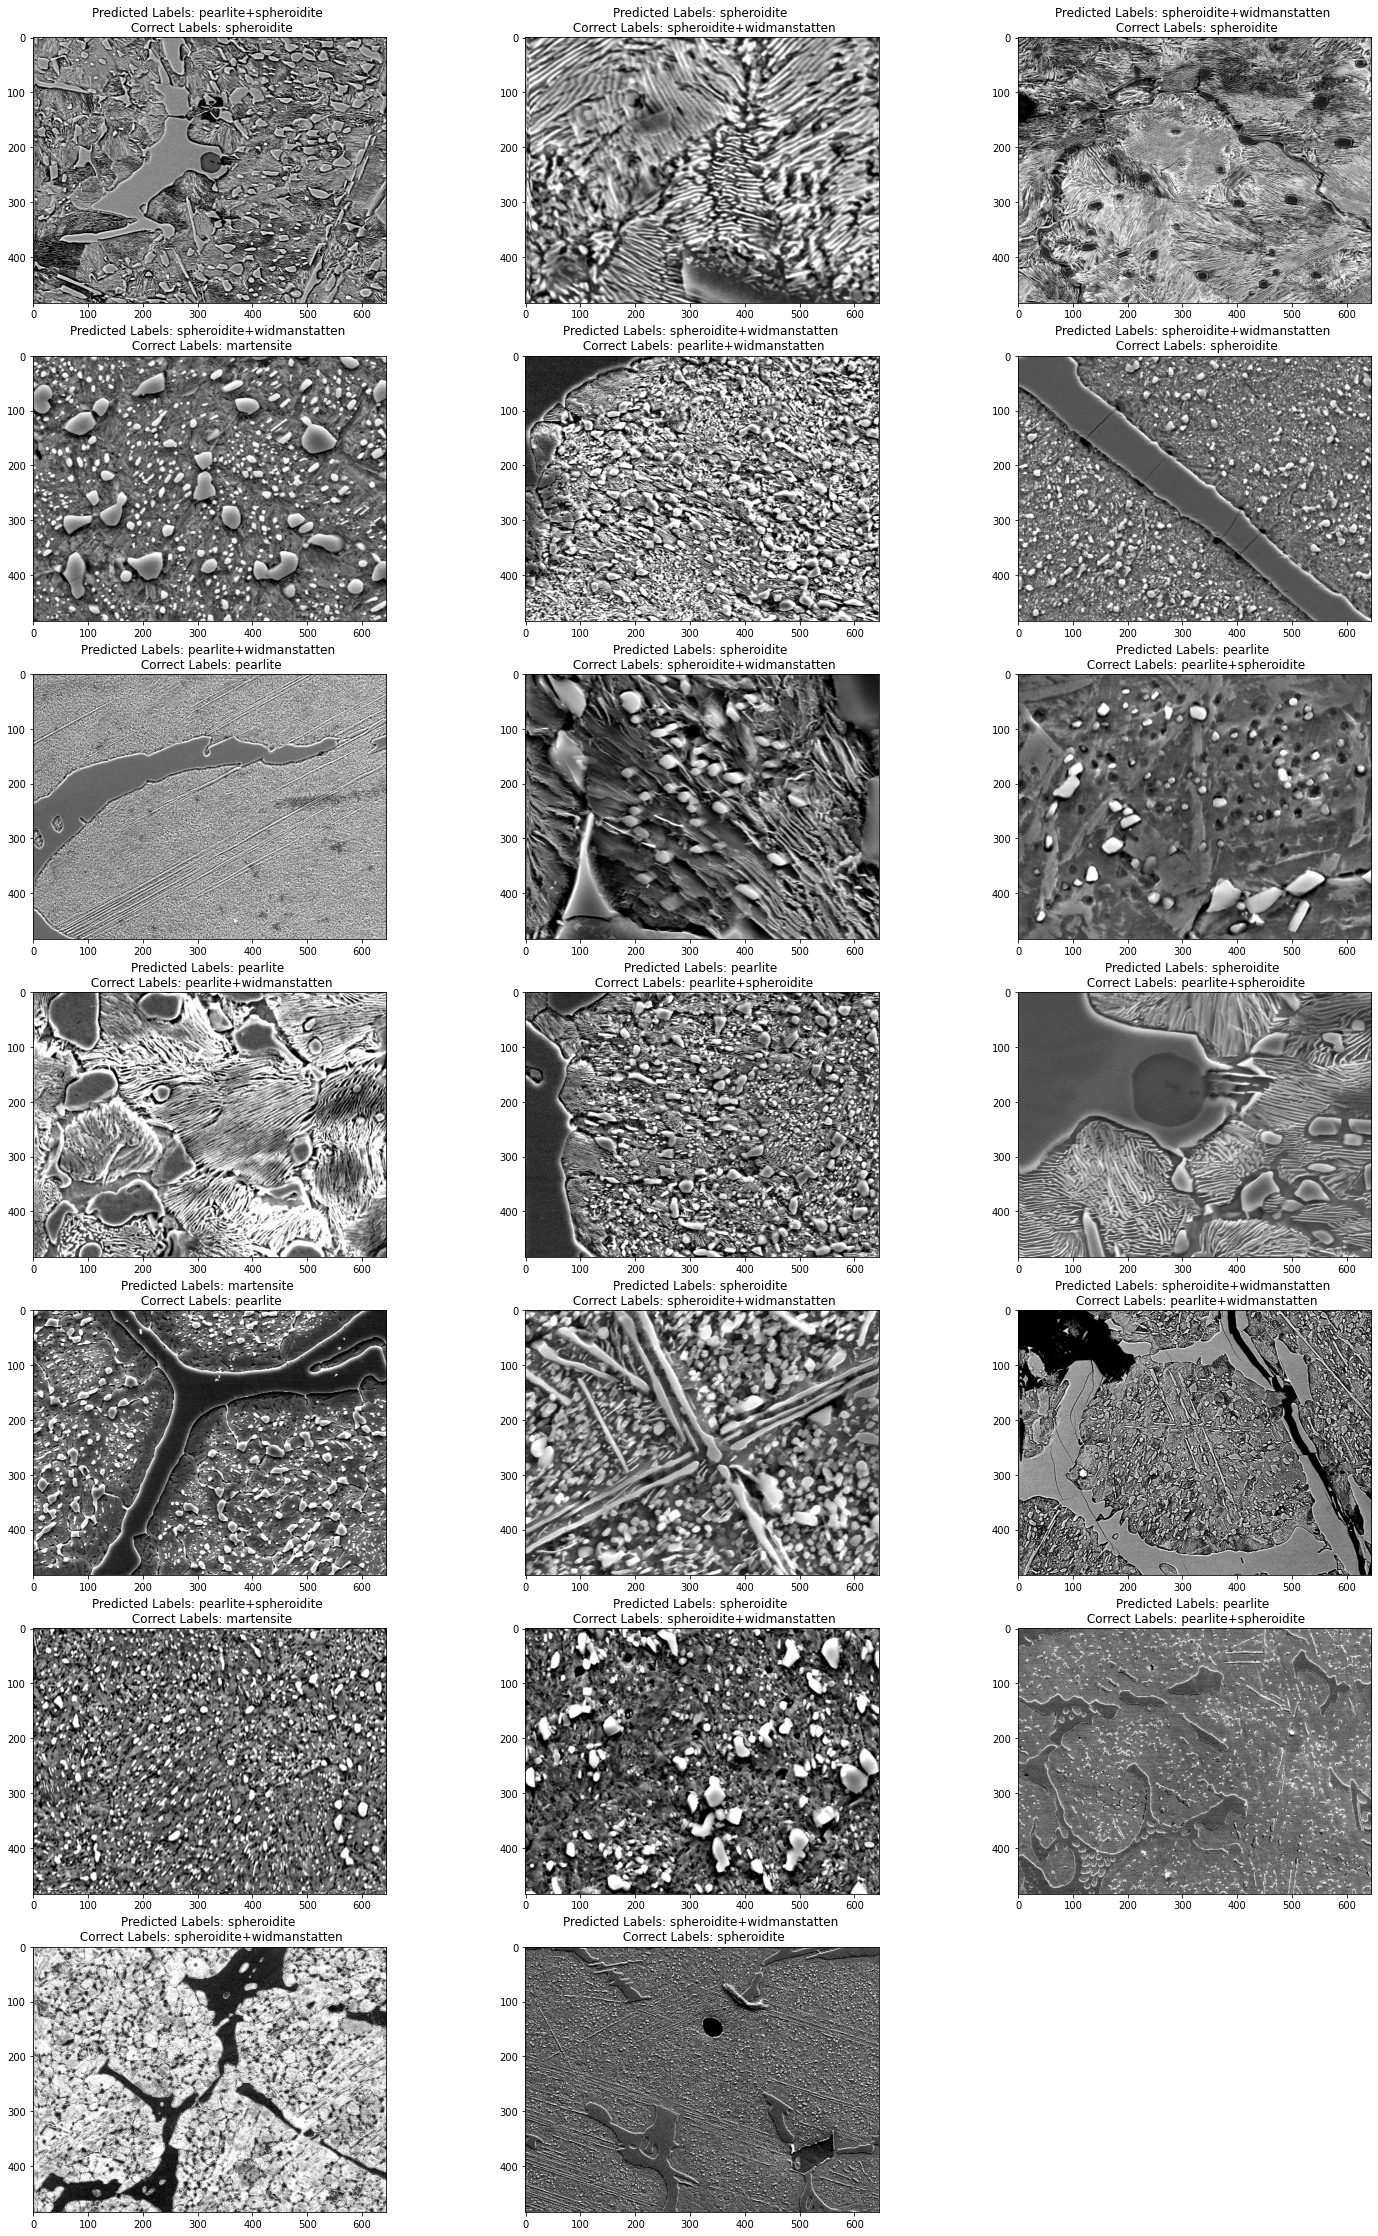

In [ ]:
class_names = train.class_names
plt.figure(figsize=(25,40))

a = 0
z = 0
l = 0

for image_batch, label_batch in validation:

  #l=l+1
  #print('l:',l)
  
  for i, images in enumerate(image_batch):

    z=z+1
    #print('z>:',z)

    if int(predicted_labels[z-1]) == np.where(correct_labels[z-1])[0][0]:

      continue

    else:
      a=a+1
      #print(a)
      ax = plt.subplot(7,3,a)
      plt.imshow(images.numpy().astype('uint8'))
      plt.title('Predicted Labels: {} \n Correct Labels: {}'.format(class_names[int(predicted_labels[z-1])], class_names[np.where(correct_labels[z-1])[0][0]]))  